# NicheNet’s ligand activity analysis on a gene set of interest: predict  active ligands and their target genes 
__________________________________
Robin Browaeys 
2019-01-17 
 
<!-- github markdown built using  
rmarkdown::render("vignettes/ligand_activity_geneset.Rmd", output_format = "github_document") 
--> 
 
In this vignette, you can learn how to perform a basic NicheNet 
analysis. A NicheNet analysis can help you to generate hypotheses about 
an intercellular communication process of interest for which you have 
bulk or single-cell gene expression data. Specifically, NicheNet can 
predict 1) which ligands from one cell population (“sender/niche”) are 
most likely to affect target gene expression in an interacting cell 
population (“receiver/target”) and 2) which specific target genes are 
affected by which of these predicted ligands. 
 
Because NicheNet studies how ligands affect gene expression in 
neighboring cells, you need to have data about this effect in gene 
expression you want to study. So, you need to have a clear set of genes 
that are putatively affected by ligands from one of more interacting 
cells. 
 
The pipeline of a basic NicheNet analysis consist mainly of the 
following steps: 
 
  - 1.  Define a “sender/niche” cell population and a “receiver/target” 
        cell population present in your expression data and determine 
        which genes are expressed in both populations 
 
  - 2.  Define a gene set of interest: these are the genes in the 
        “receiver/target” cell population that are potentially 
        affected by ligands expressed by interacting cells (e.g. genes 
        differentially expressed upon cell-cell interaction) 
 
  - 3.  Define a set of potential ligands: these are ligands that are 
        expressed by the “sender/niche” cell population and bind a 
        (putative) receptor expressed by the “receiver/target” 
        population 
 
  - 4)  Perform NicheNet ligand activity analysis: rank the potential 
        ligands based on the presence of their target genes in the gene 
        set of interest (compared to the background set of genes) 
 
  - 5)  Infer top-predicted target genes of ligands that are top-ranked 
        in the ligand activity analysis 
 
This vignette guides you in detail through all these steps. As example 
expression data of interacting cells, we will use data from Puram et 
al. to explore intercellular communication in the tumor 
microenvironment in head and neck squamous cell carcinoma (HNSCC) (See 
Puram et al. 2017). More specifically, we will look at which ligands 
expressed by cancer-associated fibroblasts (CAFs) can induce a specific 
gene program in neighboring malignant cells. This program, a partial 
epithelial-mesenschymal transition (p-EMT) program, could be linked to 
metastasis by Puram et al.  
 
The used ligand-target matrix and example expression data of interacting 
cells can be downloaded from Zenodo. 
[![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.3260758.svg)](https://doi.org/10.5281/zenodo.3260758) 
 

## Step 0: Load required packages, NicheNet’s ligand-target prior model and processed expression data of interacting cells 
 
Packages: 
 

In [1]:
library(nichenetr) 
library(tidyverse) 


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.0      ✔ purrr   1.0.1 
✔ tibble  3.1.8      ✔ dplyr   1.0.10
✔ tidyr   1.2.1      ✔ stringr 1.5.0 
✔ readr   2.1.3      ✔ forcats 0.5.2 
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


 
Ligand-target model: 
 
This model denotes the prior potential that a particular ligand might 
regulate the expression of a specific target gene. 
 


In [2]:
ligand_target_matrix = readRDS(file.path("~/FCA_Fetal_Skin_priv/", "data", "ligand_target_matrix.rds")) 
ligand_target_matrix[1:5,1:5] # target genes in rows, ligands in columns 
##                 CXCL1        CXCL2        CXCL3        CXCL5         PPBP 
## A1BG     3.534343e-04 4.041324e-04 3.729920e-04 3.080640e-04 2.628388e-04 
## A1BG-AS1 1.650894e-04 1.509213e-04 1.583594e-04 1.317253e-04 1.231819e-04 
## A1CF     5.787175e-04 4.596295e-04 3.895907e-04 3.293275e-04 3.211944e-04 
## A2M      6.027058e-04 5.996617e-04 5.164365e-04 4.517236e-04 4.590521e-04 
## A2M-AS1  8.898724e-05 8.243341e-05 7.484018e-05 4.912514e-05 5.120439e-05 

,CXCL1,CXCL2,CXCL3,CXCL5,PPBP
A1BG,3.534343e-04,4.041324e-04,3.729920e-04,3.080640e-04,2.628388e-04
A1BG-AS1,1.650894e-04,1.509213e-04,1.583594e-04,1.317253e-04,1.231819e-04
A1CF,5.787175e-04,4.596295e-04,3.895907e-04,3.293275e-04,3.211944e-04
A2M,6.027058e-04,5.996617e-04,5.164365e-04,4.517236e-04,4.590521e-04
A2M-AS1,8.898724e-05,8.243341e-05,7.484018e-05,4.912514e-05,5.120439e-05


 
Expression data of interacting cells: publicly available single-cell 
data from CAF and malignant cells from HNSCC tumors: 
 


In [3]:
hnscc_expression = readRDS(file.path("~/FCA_Fetal_Skin_priv/", "data", "hnscc_expression.rds")) 
expression = hnscc_expression$expression 
sample_info = hnscc_expression$sample_info # contains meta-information about the cells 


In [6]:
expression

,C9orf152,RPS11,ELMO2,CREB3L1,PNMA1,MMP2,TMEM216,TRAF3IP2-AS1,LRRC37A5P,LOC653712,⋯,GPLD1,SNORD115-39,RAB8A,RXFP2,PCIF1,PIK3IP1,SNRPD2,SLC39A6,CTSC,AQP7
HN28_P15_D06_S330_comb,0.00000,6.0037,0.00000,0.00000,5.14740,0.00000,0.00000,0.299830,0,0.00000,⋯,0.125650,0,0.17377,0,4.05570,0.0000,0.0000,0.00000,0.062122,0.000
HN28_P6_G05_S173_comb,0.00000,7.3006,0.00000,0.00000,5.33290,0.00000,0.00000,0.590720,0,0.00000,⋯,0.000000,0,0.00000,0,6.26410,0.0000,5.0846,0.00000,0.282140,0.000
HN26_P14_D11_S239_comb,0.42761,7.2885,0.00000,0.00000,2.83370,0.00000,3.60400,0.130930,0,0.00000,⋯,0.000000,0,0.93130,0,4.08970,3.0234,5.8272,0.00000,3.719600,0.000
HN26_P14_H05_S281_comb,0.00000,0.0000,5.24650,0.00000,5.75070,0.00000,4.99780,3.284200,0,0.00000,⋯,0.046840,0,5.54370,0,0.00000,6.2743,0.0000,0.00000,0.168640,0.000
HN26_P25_H09_S189_comb,0.00000,7.4742,0.50487,0.00000,0.19661,0.36065,0.00000,0.160920,0,0.00000,⋯,0.069015,0,0.31150,0,4.71050,3.8261,4.4258,0.00000,3.414500,0.000
HN26_P14_H06_S282_comb,0.00000,6.9548,0.00000,0.00000,1.99490,0.00000,0.00000,0.102990,0,0.00000,⋯,0.052416,0,3.91970,0,0.93584,3.6801,6.0100,2.17950,5.058100,0.000
HN25_P25_C04_S316_comb,0.00000,5.9743,0.00000,0.00000,0.00000,0.00000,0.00000,0.994940,0,0.00000,⋯,0.000000,0,0.00000,0,0.00000,0.0000,0.0000,0.00000,2.230800,0.000
HN26_P25_A11_S107_comb,0.00000,6.4650,3.41540,0.00000,2.15410,0.00000,0.86869,3.325000,0,0.00000,⋯,0.000000,0,4.28530,0,2.83110,0.0000,0.0000,0.00000,0.237560,0.000
HN26_P25_C09_S129_comb,0.00000,6.5628,0.00000,0.00000,3.58150,0.00000,0.00000,0.085425,0,0.00000,⋯,0.000000,0,0.00000,0,0.00000,0.0000,5.1215,0.00000,4.627400,0.000
HNSCC26_P24_H05_S377_comb,0.00000,7.9486,1.96130,0.00000,0.00000,0.00000,4.30960,0.657180,0,0.00000,⋯,0.000000,0,0.00000,0,0.00000,0.0000,5.4381,0.00000,0.381840,0.000


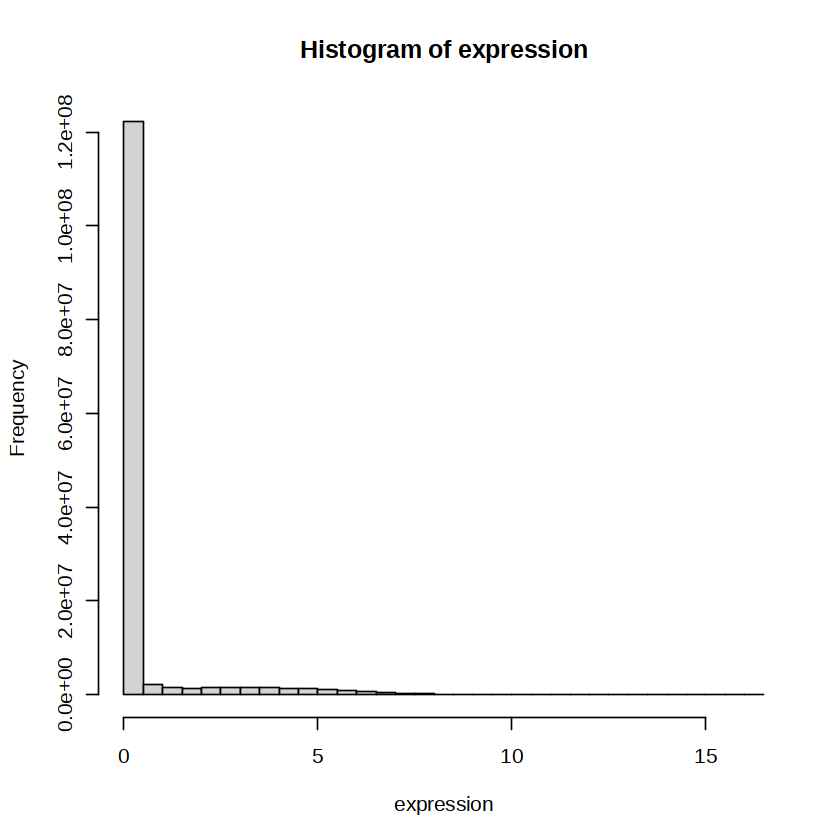

In [9]:
hist(expression)

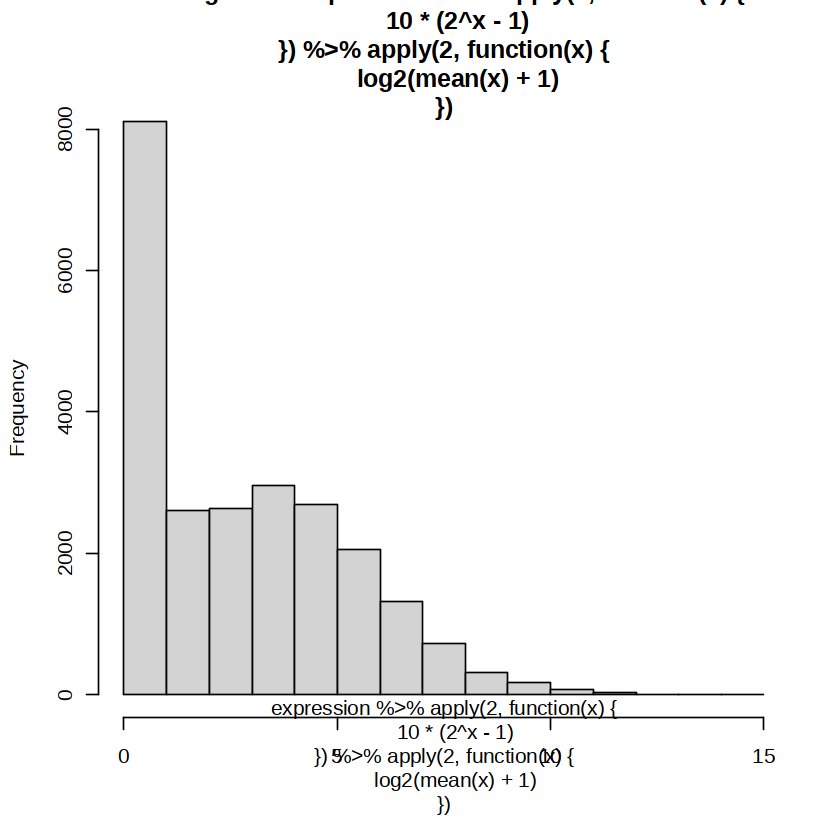

In [8]:
hist(expression %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}))

 
## Step 1: Define expressed genes in sender and receiver cell populations 
 
Our research question is to prioritize which ligands expressed by CAFs 
can induce p-EMT in neighboring malignant cells. Therefore, CAFs are the 
sender cells in this example and malignant cells are the receiver cells. 
This is an example of paracrine signaling. Note that autocrine signaling 
can be considered if sender and receiver cell type are the same. 
 
Now, we will determine which genes are expressed in the sender cells 
(CAFs) and receiver cells (malignant cells) from high quality primary 
tumors. Therefore, we wil not consider cells from tumor samples of less 
quality or from lymph node metastases. 
 
To determine expressed genes in this case study, we use the definition 
used by Puram et al. (the authors of this dataset), which is: Ea, the 
aggregate expression of each gene i across the k cells, calculated as 
Ea(i) = log2(average(TPM(i)1…k)+1), should be \>= 4. We recommend users 
to define expressed genes in the way that they consider to be most 
appropriate for their dataset. For single-cell data generated by the 10x 
platform in our lab, we don’t use the definition used here, but we 
consider genes to be expressed in a cell type when they have non-zero 
values in at least 10% of the cells from that cell type. This is 
described as well in the other vignette [Perform NicheNet analysis 
starting from a Seurat object: step-by-step 
analysis](seurat_steps.md):`vignette("seurat_steps", 
package="nichenetr")`. 
 


In [ ]:
tumors_remove = c("HN10","HN","HN12", "HN13", "HN24", "HN7", "HN8","HN23") 
 
CAF_ids = sample_info %>% filter(`Lymph node` == 0 & !(tumor %in% tumors_remove) & `non-cancer cell type` == "CAF") %>% pull(cell) 
malignant_ids = sample_info %>% filter(`Lymph node` == 0 & !(tumor %in% tumors_remove) & `classified  as cancer cell` == 1) %>% pull(cell) 
 
expressed_genes_sender = expression[CAF_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 4] %>% names() 
expressed_genes_receiver = expression[malignant_ids,] %>% apply(2,function(x){10*(2**x - 1)}) %>% apply(2,function(x){log2(mean(x) + 1)}) %>% .[. >= 4] %>% names() 
 
# Check the number of expressed genes: should be a 'reasonable' number of total expressed genes in a cell type, e.g. between 5000-10000 (and not 500 or 20000) 
length(expressed_genes_sender) 
## [1] 6706 
length(expressed_genes_receiver) 
## [1] 6351 


 
## Step 2: Define the gene set of interest and a background of genes 
 
As gene set of interest, we consider the genes of which the expression 
is possibly affected due to communication with other cells. The 
definition of this gene set depends on your research question and is a 
crucial step in the use of NicheNet. 
 
Because we here want to investigate how CAFs regulate the expression of 
p-EMT genes in malignant cells, we will use the p-EMT gene set defined 
by Puram et al. as gene set of interest and use all genes expressed in 
malignant cells as background of genes. 
 


In [ ]:
geneset_oi = readr::read_tsv(url("https://zenodo.org/record/3260758/files/pemt_signature.txt"), col_names = "gene") %>% pull(gene) %>% .[. %in% rownames(ligand_target_matrix)] # only consider genes also present in the NicheNet model - this excludes genes from the gene list for which the official HGNC symbol was not used by Puram et al. 
head(geneset_oi) 
## [1] "SERPINE1" "TGFBI"    "MMP10"    "LAMC2"    "P4HA2"    "PDPN" 
 
background_expressed_genes = expressed_genes_receiver %>% .[. %in% rownames(ligand_target_matrix)] 
head(background_expressed_genes) 
## [1] "RPS11"   "ELMO2"   "PNMA1"   "MMP2"    "TMEM216" "ERCC5" 


 
## Step 3: Define a set of potential ligands 
 
As potentially active ligands, we will use ligands that are 1) expressed 
by CAFs and 2) can bind a (putative) receptor expressed by malignant 
cells. Putative ligand-receptor links were gathered from NicheNet’s 
ligand-receptor data sources. 
 


In [ ]:
lr_network = readRDS(url("https://zenodo.org/record/3260758/files/lr_network.rds")) 
 
# If wanted, users can remove ligand-receptor interactions that were predicted based on protein-protein interactions and only keep ligand-receptor interactions that are described in curated databases. To do this: uncomment following line of code: 
# lr_network = lr_network %>% filter(database != "ppi_prediction_go" & database != "ppi_prediction") 
 
ligands = lr_network %>% pull(from) %>% unique() 
expressed_ligands = intersect(ligands,expressed_genes_sender) 
 
receptors = lr_network %>% pull(to) %>% unique() 
expressed_receptors = intersect(receptors,expressed_genes_receiver) 
 
lr_network_expressed = lr_network %>% filter(from %in% expressed_ligands & to %in% expressed_receptors)  
head(lr_network_expressed) 
## # A tibble: 6 x 4 
##   from    to        source         database 
##   <chr>   <chr>     <chr>          <chr>    
## 1 HGF     MET       kegg_cytokines kegg     
## 2 TNFSF10 TNFRSF10A kegg_cytokines kegg     
## 3 TNFSF10 TNFRSF10B kegg_cytokines kegg     
## 4 TGFB2   TGFBR1    kegg_cytokines kegg     
## 5 TGFB3   TGFBR1    kegg_cytokines kegg     
## 6 INHBA   ACVR2A    kegg_cytokines kegg 


 
This ligand-receptor network contains the expressed ligand-receptor 
interactions. As potentially active ligands for the NicheNet analysis, 
we will consider the ligands from this network. 
 


In [ ]:
potential_ligands = lr_network_expressed %>% pull(from) %>% unique() 
head(potential_ligands) 
## [1] "HGF"     "TNFSF10" "TGFB2"   "TGFB3"   "INHBA"   "CD99" 


 
## Step 4: Perform NicheNet’s ligand activity analysis on the gene set of interest 
 
Now perform the ligand activity analysis: in this analysis, we will 
calculate the ligand activity of each ligand, or in other words, we will 
assess how well each CAF-ligand can predict the p-EMT gene set compared 
to the background of expressed genes (predict whether a gene belongs to 
the p-EMT program or not). 
 


In [ ]:
ligand_activities = predict_ligand_activities(geneset = geneset_oi, background_expressed_genes = background_expressed_genes, ligand_target_matrix = ligand_target_matrix, potential_ligands = potential_ligands) 



 
Now, we want to rank the ligands based on their ligand activity. In our 
validation study, we showed that the pearson correlation coefficient 
(PCC) between a ligand’s target predictions and the observed 
transcriptional response was the most informative measure to define 
ligand activity. Therefore, we will rank the ligands based on their 
pearson correlation coefficient. This allows us to prioritize 
p-EMT-regulating ligands. 
 


In [ ]:
ligand_activities %>% arrange(-pearson)  
## # A tibble: 131 x 4 
##    test_ligand auroc   aupr pearson 
##    <chr>       <dbl>  <dbl>   <dbl> 
##  1 PTHLH       0.667 0.0720   0.128 
##  2 CXCL12      0.680 0.0507   0.123 
##  3 AGT         0.676 0.0581   0.120 
##  4 TGFB3       0.689 0.0454   0.117 
##  5 IL6         0.693 0.0510   0.115 
##  6 INHBA       0.695 0.0502   0.113 
##  7 ADAM17      0.672 0.0526   0.113 
##  8 TNC         0.700 0.0444   0.109 
##  9 CTGF        0.680 0.0473   0.108 
## 10 FN1         0.679 0.0505   0.108 
## # ... with 121 more rows 
best_upstream_ligands = ligand_activities %>% top_n(20, pearson) %>% arrange(-pearson) %>% pull(test_ligand) 
head(best_upstream_ligands) 
## [1] "PTHLH"  "CXCL12" "AGT"    "TGFB3"  "IL6"    "INHBA" 


 
We see here that the performance metrics indicate that the 20 top-ranked 
ligands can predict the p-EMT genes reasonably, this implies that 
ranking of the ligands might be accurate as shown in our study. However, 
it is possible that for some gene sets, the target gene prediction 
performance of the top-ranked ligands would not be much better than 
random prediction. In that case, prioritization of ligands will be less 
trustworthy. 
 
Additional note: we looked at the top 20 ligands here and will continue 
the analysis by inferring p-EMT target genes of these 20 ligands. 
However, the choice of looking only at the 20 top-ranked ligands for 
further biological interpretation is based on biological intuition and 
is quite arbitrary. Therefore, users can decide to continue the analysis 
with a different number of ligands. We recommend to check the selected 
cutoff by looking at the distribution of the ligand activity values. 
Here, we show the ligand activity histogram (the score for the 20th 
ligand is indicated via the dashed line). 
 


In [ ]:
# show histogram of ligand activity scores 
p_hist_lig_activity = ggplot(ligand_activities, aes(x=pearson)) +  
  geom_histogram(color="black", fill="darkorange")  +  
  # geom_density(alpha=.1, fill="orange") + 
  geom_vline(aes(xintercept=min(ligand_activities %>% top_n(20, pearson) %>% pull(pearson))), color="red", linetype="dashed", size=1) +  
  labs(x="ligand activity (PCC)", y = "# ligands") + 
  theme_classic() 
p_hist_lig_activity 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-10-1.png)<!-- --> 
 
## Step 5: Infer target genes of top-ranked ligands and visualize in a heatmap 
 
Now we will show how you can look at the regulatory potential scores 
between ligands and target genes of interest. In this case, we will look 
at links between top-ranked p-EMT regulating ligands and p-EMT genes. In 
the ligand-target heatmaps, we show here regulatory potential scores for 
interactions between the 20 top-ranked ligands and following target 
genes: genes that belong to the gene set of interest and to the 250 most 
strongly predicted targets of at least one of the 20 top-ranked ligands 
(the top 250 targets according to the general prior model, so not the 
top 250 targets for this dataset). Consequently, genes of your gene set 
that are not a top target gene of one of the prioritized ligands, will 
not be shown on the heatmap. 
 


In [ ]:
active_ligand_target_links_df = best_upstream_ligands %>% lapply(get_weighted_ligand_target_links,geneset = geneset_oi, ligand_target_matrix = ligand_target_matrix, n = 250) %>% bind_rows() 
 
nrow(active_ligand_target_links_df) 
## [1] 143 
head(active_ligand_target_links_df) 
## # A tibble: 6 x 3 
##   ligand target  weight 
##   <chr>  <chr>    <dbl> 
## 1 PTHLH  COL1A1 0.00399 
## 2 PTHLH  MMP1   0.00425 
## 3 PTHLH  MMP2   0.00210 
## 4 PTHLH  MYH9   0.00116 
## 5 PTHLH  P4HA2  0.00190 
## 6 PTHLH  PLAU   0.00401 


 
For visualization purposes, we adapted the ligand-target regulatory 
potential matrix as follows. Regulatory potential scores were set as 0 
if their score was below a predefined threshold, which was here the 0.25 
quantile of scores of interactions between the 20 top-ranked ligands and 
each of their respective top targets (see the ligand-target network 
defined in the data frame). 
 


In [ ]:
active_ligand_target_links = prepare_ligand_target_visualization(ligand_target_df = active_ligand_target_links_df, ligand_target_matrix = ligand_target_matrix, cutoff = 0.25) 
 
nrow(active_ligand_target_links_df) 
## [1] 143 
head(active_ligand_target_links_df) 
## # A tibble: 6 x 3 
##   ligand target  weight 
##   <chr>  <chr>    <dbl> 
## 1 PTHLH  COL1A1 0.00399 
## 2 PTHLH  MMP1   0.00425 
## 3 PTHLH  MMP2   0.00210 
## 4 PTHLH  MYH9   0.00116 
## 5 PTHLH  P4HA2  0.00190 
## 6 PTHLH  PLAU   0.00401 


 
The putatively active ligand-target links will now be visualized in a 
heatmap. The order of the ligands accord to the ranking according to the 
ligand activity prediction. 
 


In [ ]:
order_ligands = intersect(best_upstream_ligands, colnames(active_ligand_target_links)) %>% rev() 
order_targets = active_ligand_target_links_df$target %>% unique() 
vis_ligand_target = active_ligand_target_links[order_targets,order_ligands] %>% t() 
 
p_ligand_target_network = vis_ligand_target %>% make_heatmap_ggplot("Prioritized CAF-ligands","p-EMT genes in malignant cells", color = "purple",legend_position = "top", x_axis_position = "top",legend_title = "Regulatory potential") + scale_fill_gradient2(low = "whitesmoke",  high = "purple", breaks = c(0,0.005,0.01)) + theme(axis.text.x = element_text(face = "italic")) 
 
p_ligand_target_network 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-13-1.png)<!-- --> 
 
Note that the choice of these cutoffs for visualization is quite 
arbitrary. We recommend users to test several cutoff values. 
 
If you would consider more than the top 250 targets based on prior 
information, you will infer more, but less confident, ligand-target 
links; by considering less than 250 targets, you will be more stringent. 
 
If you would change the quantile cutoff that is used to set scores to 0 
(for visualization purposes), lowering this cutoff will result in a more 
dense heatmap, whereas highering this cutoff will result in a more 
sparse heatmap. 
 
## Follow-up analysis 1: Ligand-receptor network inference for top-ranked ligands 
 
One type of follow-up analysis is looking at which receptors of the 
receiver cell population (here: malignant cells) can potentially bind to 
the prioritized ligands from the sender cell population (here: CAFs). 
 
So, we will now infer the predicted ligand-receptor interactions of the 
top-ranked ligands and visualize these in a heatmap. 
 


In [ ]:
# get the ligand-receptor network of the top-ranked ligands 
lr_network_top = lr_network %>% filter(from %in% best_upstream_ligands & to %in% expressed_receptors) %>% distinct(from,to) 
best_upstream_receptors = lr_network_top %>% pull(to) %>% unique() 
 
# get the weights of the ligand-receptor interactions as used in the NicheNet model 
weighted_networks = readRDS(url("https://zenodo.org/record/3260758/files/weighted_networks.rds")) 
lr_network_top_df = weighted_networks$lr_sig %>% filter(from %in% best_upstream_ligands & to %in% best_upstream_receptors) 
 
# convert to a matrix 
lr_network_top_df = lr_network_top_df %>% spread("from","weight",fill = 0) 
lr_network_top_matrix = lr_network_top_df %>% select(-to) %>% as.matrix() %>% magrittr::set_rownames(lr_network_top_df$to) 
 
# perform hierarchical clustering to order the ligands and receptors 
dist_receptors = dist(lr_network_top_matrix, method = "binary") 
hclust_receptors = hclust(dist_receptors, method = "ward.D2") 
order_receptors = hclust_receptors$labels[hclust_receptors$order] 
 
dist_ligands = dist(lr_network_top_matrix %>% t(), method = "binary") 
hclust_ligands = hclust(dist_ligands, method = "ward.D2") 
order_ligands_receptor = hclust_ligands$labels[hclust_ligands$order] 


 
Show a heatmap of the ligand-receptor interactions 
 


In [ ]:
vis_ligand_receptor_network = lr_network_top_matrix[order_receptors, order_ligands_receptor] 
p_ligand_receptor_network = vis_ligand_receptor_network %>% t() %>% make_heatmap_ggplot("Prioritized CAF-ligands","Receptors expressed by malignant cells", color = "mediumvioletred", x_axis_position = "top",legend_title = "Prior interaction potential") 
p_ligand_receptor_network 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-15-1.png)<!-- --> 
 
## Follow-up analysis 2: Visualize expression of top-predicted ligands and their target genes in a combined heatmap 
 
NicheNet only considers expressed ligands of sender cells, but does not 
take into account their expression for ranking the ligands. The ranking 
is purely based on the potential that a ligand might regulate the gene 
set of interest, given prior knowledge. Because it is also useful to 
further look into expression of ligands and their target genes, we 
demonstrate here how you could make a combined figure showing ligand 
activity, ligand expression, target gene expression and ligand-target 
regulatory potential. 
 
#### Load additional packages required for the visualization: 
 


In [ ]:
library(RColorBrewer) 
library(cowplot) 
library(ggpubr) 


 
#### Prepare the ligand activity matrix 
 


In [ ]:
ligand_pearson_matrix = ligand_activities %>% select(pearson) %>% as.matrix() %>% magrittr::set_rownames(ligand_activities$test_ligand) 
 
vis_ligand_pearson = ligand_pearson_matrix[order_ligands, ] %>% as.matrix(ncol = 1) %>% magrittr::set_colnames("Pearson") 


In [ ]:
p_ligand_pearson = vis_ligand_pearson %>% make_heatmap_ggplot("Prioritized CAF-ligands","Ligand activity", color = "darkorange",legend_position = "top", x_axis_position = "top", legend_title = "Pearson correlation coefficient\ntarget gene prediction ability)") 
p_ligand_pearson 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-18-1.png)<!-- --> 
 
#### Prepare expression of ligands in fibroblast per tumor 
 
Because the single-cell data was collected from multiple tumors, we will 
show here the average expression of the ligands per tumor. 
 


In [ ]:
expression_df_CAF = expression[CAF_ids,order_ligands] %>% data.frame() %>% rownames_to_column("cell") %>% as_tibble() %>% inner_join(sample_info %>% select(cell,tumor), by =  "cell") 
 
aggregated_expression_CAF = expression_df_CAF %>% group_by(tumor) %>% select(-cell) %>% summarise_all(mean) 
 
aggregated_expression_df_CAF = aggregated_expression_CAF %>% select(-tumor) %>% t() %>% magrittr::set_colnames(aggregated_expression_CAF$tumor) %>% data.frame() %>% rownames_to_column("ligand") %>% as_tibble()  
 
aggregated_expression_matrix_CAF = aggregated_expression_df_CAF %>% select(-ligand) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_CAF$ligand) 
 
order_tumors = c("HN6","HN20","HN26","HN28","HN22","HN25","HN5","HN18","HN17","HN16") # this order was determined based on the paper from Puram et al. Tumors are ordered according to p-EMT score. 
vis_ligand_tumor_expression = aggregated_expression_matrix_CAF[order_ligands,order_tumors] 


In [ ]:
library(RColorBrewer) 
color = colorRampPalette(rev(brewer.pal(n = 7, name ="RdYlBu")))(100) 
p_ligand_tumor_expression = vis_ligand_tumor_expression %>% make_heatmap_ggplot("Prioritized CAF-ligands","Tumor", color = color[100],legend_position = "top", x_axis_position = "top", legend_title = "Expression\n(averaged over\nsingle cells)") + theme(axis.text.y = element_text(face = "italic")) 
p_ligand_tumor_expression 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-20-1.png)<!-- --> 
 
#### Prepare expression of target genes in malignant cells per tumor 
 


In [ ]:
expression_df_target = expression[malignant_ids,geneset_oi] %>% data.frame() %>% rownames_to_column("cell") %>% as_tibble() %>% inner_join(sample_info %>% select(cell,tumor), by =  "cell")  
 
aggregated_expression_target = expression_df_target %>% group_by(tumor) %>% select(-cell) %>% summarise_all(mean) 
 
aggregated_expression_df_target = aggregated_expression_target %>% select(-tumor) %>% t() %>% magrittr::set_colnames(aggregated_expression_target$tumor) %>% data.frame() %>% rownames_to_column("target") %>% as_tibble()  
 
aggregated_expression_matrix_target = aggregated_expression_df_target %>% select(-target) %>% as.matrix() %>% magrittr::set_rownames(aggregated_expression_df_target$target) 
 
vis_target_tumor_expression_scaled = aggregated_expression_matrix_target %>% t() %>% scale_quantile() %>% .[order_tumors,order_targets] 


In [ ]:
p_target_tumor_scaled_expression = vis_target_tumor_expression_scaled  %>% make_threecolor_heatmap_ggplot("Tumor","Target", low_color = color[1],mid_color = color[50], mid = 0.5, high_color = color[100], legend_position = "top", x_axis_position = "top" , legend_title = "Scaled expression\n(averaged over\nsingle cells)") + theme(axis.text.x = element_text(face = "italic")) 
p_target_tumor_scaled_expression 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-22-1.png)<!-- --> 
 
#### Combine the different heatmaps in one overview figure 
 


In [ ]:
figures_without_legend = plot_grid( 
  p_ligand_pearson + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()), 
  p_ligand_tumor_expression + theme(legend.position = "none", axis.ticks = element_blank()) + theme(axis.title.x = element_text()) + ylab(""), 
  p_ligand_target_network + theme(legend.position = "none", axis.ticks = element_blank()) + ylab(""),  
  NULL, 
  NULL, 
  p_target_tumor_scaled_expression + theme(legend.position = "none", axis.ticks = element_blank()) + xlab(""),  
  align = "hv", 
  nrow = 2, 
  rel_widths = c(ncol(vis_ligand_pearson)+ 4.5, ncol(vis_ligand_tumor_expression), ncol(vis_ligand_target)) -2, 
  rel_heights = c(nrow(vis_ligand_pearson), nrow(vis_target_tumor_expression_scaled) + 3))  
 
legends = plot_grid( 
  as_ggplot(get_legend(p_ligand_pearson)), 
  as_ggplot(get_legend(p_ligand_tumor_expression)), 
  as_ggplot(get_legend(p_ligand_target_network)), 
  as_ggplot(get_legend(p_target_tumor_scaled_expression)), 
  nrow = 2, 
  align = "h") 
 
plot_grid(figures_without_legend,  
          legends,  
          rel_heights = c(10,2), nrow = 2, align = "hv") 


 
![](ligand_activity_geneset_files/figure-gfm/unnamed-chunk-23-1.png)<!-- --> 
 
## Other follow-up analyses: 
 
As another follow-up analysis, you can infer possible signaling paths 
between ligands and targets of interest. You can read how to do this in 
the following vignette [Inferring ligand-to-target signaling 
paths](ligand_target_signaling_path.md):`vignette("ligand_target_signaling_path", 
package="nichenetr")`. 
 
Another follow-up analysis is getting a “tangible” measure of how well 
top-ranked ligands predict the gene set of interest and assess which 
genes of the gene set can be predicted well. You can read how to do this 
in the following vignette [Assess how well top-ranked ligands can 
predict a gene set of 
interest](target_prediction_evaluation_geneset.md):`vignette("target_prediction_evaluation_geneset", 
package="nichenetr")`. 
 
In case you want to visualize ligand-target links between multiple 
interacting cells, you can make an appealing circos plot as shown in 
vignette [Circos plot visualization to show active ligand-target links 
between interacting cells](circos.md):`vignette("circos", 
package="nichenetr")`. 
 
## References 
 
<div id="refs" class="references"> 
 
<div id="ref-puram_single-cell_2017"> 
 
Puram, Sidharth V., Itay Tirosh, Anuraag S. Parikh, Anoop P. Patel, 
Keren Yizhak, Shawn Gillespie, Christopher Rodman, et al. 2017. 
“Single-Cell Transcriptomic Analysis of Primary and Metastatic Tumor 
Ecosystems in Head and Neck Cancer.” *Cell* 171 (7): 1611–1624.e24. 
<https://doi.org/10.1016/j.cell.2017.10.044>. 
 
</div> 
 
</div> 
